<a href="https://colab.research.google.com/github/filippomenegatti/NeuralNetwork_ClassificationProj/blob/main/Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with Neural Networks
Use `tensorflow` to train neural networks for the classification of fruit/vegetable types based on images from this dataset. Images must be transformed from JPG to RGB pixel values and scaled down (e.g., 32x32).  
Use fruit/vegetable types (as opposed to variety) as labels to predict and consider only the 10 most frequent types (apple, banana, plum, pepper, cherry, grape, tomato, potato, pear, peach).  
Experiment with different network architectures and training parameters documenting their influence of the final predictive performance. While the training loss can be chosen freely, the reported test errors must be measured according to the zero-one loss for multiclass classification.

# Introduction

In these essay we are going to analyse the dataset available on Kaggle website [1] under the license CC BY-SA 4.0, using a Deep Learning approach. The dataset contains 90380 images of 131 fruits and vegetables divided in folders for training and test set respectively. We are going to select just a subsample of the available fruits creating 10 macrocategories with the most frequent types. Different Neural Networks architectures will be compared, starting from different settings of the "basic" Feedforward Neural Network and concluding with a Convolutional Neural Network model.



# Setting up the environment

In this session we are going to set up our working environment installing the dependencies needed to download the dataset from kaggle and importing the libraries that will be used in the analysis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

files.upload() #import the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"filippomenegatti","key":"edbf8396c254a2e275c3317efacf9f85"}'}

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d moltean/fruits
!mkdir ML_assignment
!unzip fruits.zip -d ML_assignment

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold


import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, Activation, MaxPooling2D, Input, AveragePooling2D, GlobalAveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD, RMSprop, Adamax
from keras import regularizers
from keras.callbacks import LearningRateScheduler, History, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

print('The Tensorflow version used is: ' + tf.__version__)
print('The Keras version used is: ' + keras.__version__)

In [ ]:
seed = 33
random.seed(seed)
tf.random.set_seed(seed)

# Dataset preprocessing

In this section we are going to divide the downloaded dataset into the ten macro-categories requested: Apple, Banana, Plum, Pepper, Cherry, Grape, Tomato, Potato, Pear, Peach.  
The images are sized down from 100x100x3 to 32x32x3.

In [ ]:
file_path = '/content/ML_assignment/fruits-360'

In [ ]:
types = ["Apple", "Banana", "Plum", "Pepper", "Cherry", "Grape", "Tomato", "Potato", "Pear", "Peach"]

fruits = {}

def load_dataset(dire):
    fruits = {}
    images_as_array = []
    labels =[]
    for category in os.listdir(dire):
        for typ in types:
            if(category.split()[0] == typ):
                fruits[category]= typ
                path = os.path.join(dire,category)
                class_num =types.index(fruits[category])

                class_name = fruits[category]
                for img in os.listdir(path):
                    file = os.path.join(path,img)
                    images_as_array.append(img_to_array(load_img(file,target_size=(32, 32))))
                    labels.append(class_num)
    images_as_array =  np.array(images_as_array)
    labels = np.array(labels)
    return images_as_array, labels

In [ ]:
train_path= '/content/ML_assignment/fruits-360/Training'
test_path= '/content/ML_assignment/fruits-360/Test'

In [ ]:
train = load_dataset(train_path)
test = load_dataset(test_path)

In [ ]:
X_train, y_train = train
X_test, y_test = test

In [ ]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(32607, 32, 32, 3)
(10906, 32, 32, 3)


In [ ]:
n_classes = len(np.unique(y_train))
n_classes

10

We are now going to plot the frequency of the different classes in Test and Training set, so to control if they are balanced.

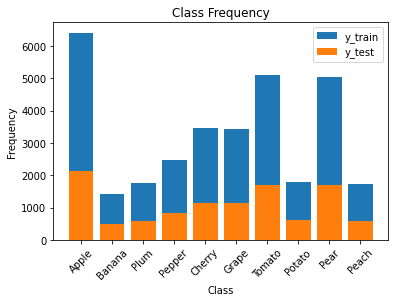

In [ ]:
#look at the distribution of the classes in the sets

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(types, counts)

unique, counts = np.unique(y_test, return_counts=True)
plt.bar(types, counts)

plt.xticks(rotation=45)
plt.gca().legend(('y_train','y_test'))
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

Since the starting dataset is already divided into Training set and Test set, so we are going to proceed dividing the Training one into a Validation (or Development) set, that will be used to tune the hyperparameters of the model and for calculating the Validation Accuracy, which will be our benchmark for the "Early Stopping" of the model. The Validation set is set to be 20% of the size of the Training.

In [ ]:
X_val, X_train, y_val, y_train  = train_test_split(X_train, y_train, train_size = 0.20)

After dividing the sets we are going to divide the features by 255, because the pixel intensity of each color channel is represented as a byte which goes from 0 to 255. In this way we obtain floats ranging from 0 to 1.

In [ ]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
X_val = X_val.astype('float32')/255

In [ ]:
print('Training X:\n',X_train.shape)
print('\nVaildation X:\n',X_val.shape)
print('\nTest X:\n',X_test.shape)

Training X:
 (26086, 32, 32, 3)

Vaildation X:
 (6521, 32, 32, 3)

Test X:
 (10906, 32, 32, 3)


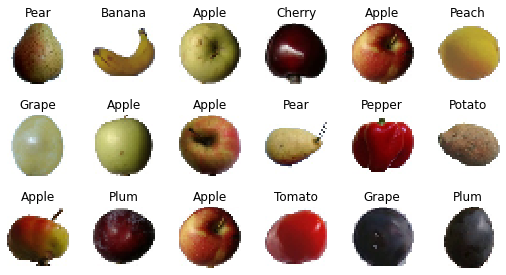

In [ ]:
n_rows = 3
n_cols = 6
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(types[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
y_train = np_utils.to_categorical(y_train, n_classes)
y_val = np_utils.to_categorical(y_val, n_classes)
y_test = np_utils.to_categorical(y_test, n_classes)

As requested for this project, the final loss function will be the zero one loss, designed as follow:

In [ ]:
def zo_loss(test, pred):
    y_hat = []
    y_t = []
    for i in range(len(pred)):
        y_hat.append(np.argmax(pred[i]))
        y_t.append(np.argmax(test[i]))

   
    loss = []
    for i in range(len(pred)):
        if(y_hat[i] == y_t[i]):
            loss.append(0)
        else:
            loss.append(1)


    return np.mean(loss)

# First try *standard* architecture

In [ ]:
model1 = keras.Sequential()
model1.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model1.add(keras.layers.Dense(1000, activation="relu"))
model1.add(keras.layers.Dense(400, activation="relu"))
model1.add(keras.layers.Dense(10, activation="softmax"))

model1.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = "sgd",
              metrics = ["accuracy"])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              3073000   
_________________________________________________________________
dense_3 (Dense)              (None, 400)               400400    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                4010      
Total params: 3,477,410
Trainable params: 3,477,410
Non-trainable params: 0
_________________________________________________________________


Fitting of the model

In [ ]:
%%time

history1 = model1.fit(X_train, y_train, epochs=30,
                    validation_data=(X_val, y_val), 
                    verbose = 1, 
                    callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]
                    )

In [ ]:
model1.evaluate(X_train, y_train)
model1.evaluate(X_test, y_test)

341/341 [==============================] - 1s 3ms/step - loss: 0.1655 - accuracy: 0.9442


[0.16553333401679993, 0.9441591501235962]

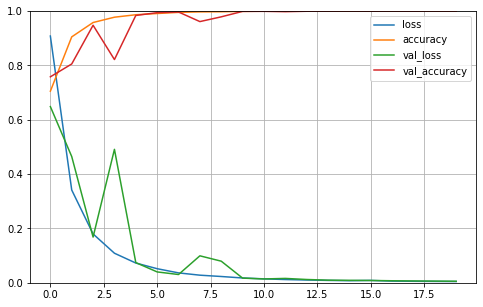

In [ ]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
y_pred1 = model1.predict(X_test)
zo_loss(y_test, y_pred1)

0.0558408215661104

The batch size defines the number of samples that will be propagated through the network.  
For instance, let’s say you have 1000 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated all samples through the network.

The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches.

In [ ]:
# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
epochs = 30
decay_rate = 1e-6
momentum = 0.9
learning_rate = 0.01
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate, early_stop]

In [ ]:
model2 = keras.Sequential()
model2.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model2.add(keras.layers.Dense(1000, activation="relu"))
model2.add(keras.layers.Dense(400, activation="relu"))
model2.add(keras.layers.Dense(10, activation="softmax"))

model2.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = sgd,
              metrics = ["accuracy"])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              3073000   
_________________________________________________________________
dense_6 (Dense)              (None, 400)               400400    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                4010      
Total params: 3,477,410
Trainable params: 3,477,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

model2_history = model2.fit(X_train, y_train, epochs=epochs, 
                            verbose=1, callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

In [ ]:
model2.evaluate(X_train, y_train)
model2.evaluate(X_test, y_test)

341/341 [==============================] - 1s 3ms/step - loss: 0.1754 - accuracy: 0.9520


[0.17537622153759003, 0.9519530534744263]

In [ ]:
y_pred2 = model2.predict(X_test)
zo_loss(y_test, y_pred2)

0.03961122317990097

Next we will try to change the setup adding regularization terms to the first setup.  

### Dropout  
At every iteration, it randomly selects some nodes - given a certain probability - and removes them along with all of their incoming and outgoing connections.

In [ ]:
model3 = keras.Sequential()
model3.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model3.add(keras.layers.Dense(1000, activation="relu"))
model3.add(keras.layers.Dropout(0.1))
model3.add(keras.layers.Dense(400, activation="relu"))
model3.add(keras.layers.Dropout(0.2))
model3.add(keras.layers.Dense(10, activation="softmax"))

model3.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = sgd,
              metrics = ["accuracy"])

model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1000)              3073000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 400)               400400    
_________________________________________________________________
dropout_7 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                4010      
Total params: 3,477,410
Trainable params: 3,477,410
Non-trainable params: 0
____________________________________________

In [ ]:
%%time

history3 = model3.fit(X_train, y_train, epochs=epochs, 
                            verbose=1, callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

In [ ]:
print(model3.evaluate(X_train, y_train))
print(model3.evaluate(X_test, y_test))

816/816 [==============================] - 3s 3ms/step - loss: 0.0031 - accuracy: 0.9992
[0.003137561958283186, 0.9992333054542542]
341/341 [==============================] - 1s 3ms/step - loss: 0.2197 - accuracy: 0.9517
[0.21973490715026855, 0.9516779780387878]


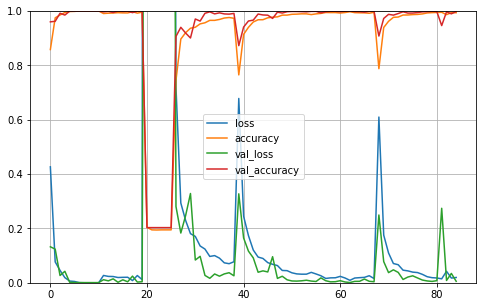

0.0483220245736292

In [ ]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

y_pred3 = model3.predict(X_test)
zo_loss(y_test, y_pred3)

Adding the dropout in the final layer slightly improved the model accuracy.

In [ ]:
model4 = keras.Sequential()
model4.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model4.add(keras.layers.Dense(1000, activation="relu", kernel_regularizer=regularizers.l1_l2()))
model4.add(keras.layers.Dense(400, activation="relu", kernel_regularizer=regularizers.l1_l2()))
model4.add(keras.layers.Dense(10, activation="softmax"))

model4.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = sgd,
              metrics = ["accuracy"])

model4.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 1000)              3073000   
_________________________________________________________________
dense_24 (Dense)             (None, 400)               400400    
_________________________________________________________________
dense_25 (Dense)             (None, 10)                4010      
Total params: 3,477,410
Trainable params: 3,477,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

history4 = model4.fit(X_train, y_train, epochs=epochs, 
                            verbose=1, callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

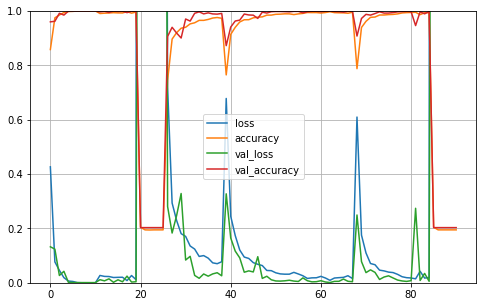

816/816 [==============================] - 3s 4ms/step - loss: 5.0308 - accuracy: 0.1947
[5.030827045440674, 0.19474047422409058]
341/341 [==============================] - 1s 4ms/step - loss: 5.0308 - accuracy: 0.1957
[5.030761241912842, 0.19567210972309113]
0.8043278929029892


In [ ]:
pd.DataFrame(history4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

print(model4.evaluate(X_train, y_train))
print(model4.evaluate(X_test, y_test))

y_pred4 = model4.predict(X_test)
print(zo_loss(y_test, y_pred4))

# Hyperparameters Tuning

In [ ]:
def create_model(optimizer = 'adam'):

    model = Sequential()
    model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
    model.add(Dense(1000, activation=tf.nn.relu))
    model.add(Dense(400, activation=tf.nn.relu))
    model.add(Dense(10, activation=tf.nn.softmax))
 
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    return model

In [ ]:
epochs = 30

model_CV = KerasClassifier(build_fn=create_model, epochs=epochs, verbose=1)

# define the grid search parameters

optimizer = ['adam', 'rmsprop', 'adamax', 'nadam']

param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_train, y_train, callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

In [ ]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.5}, std={stdev:.5} using {param}')

Best Accuracy for 0.9997699737548829 using {'optimizer': 'adamax'}
 mean=0.92919, std=0.033816 using {'optimizer': 'adam'}
 mean=0.35529, std=0.067135 using {'optimizer': 'rmsprop'}
 mean=0.99977, std=0.00022355 using {'optimizer': 'adamax'}
 mean=0.19681, std=0.0093872 using {'optimizer': 'nadam'}


The best optimizers we found with this setting are SGD and Adamax, so we will continue the optimization process using them.

In [ ]:
def create_model_SGD(nl1=1, nl2=1,  nl3=1, 
                 nn1=200, nn2=100, nn3 = 50, l1=0.01, l2=0.01,
                 dropout=0, output_shape=10, opt = sgd, act = 'relu'):
    
    
    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)
                                                     
    model = Sequential()
    model.add(Flatten(input_shape=[32, 32, 3]))

    first=True
    
    for i in range(nl1):
        if first:
            model.add(Dense(nn1, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn1, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))
            
    for i in range(nl2):
        if first:
            model.add(Dense(nn2, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn2, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))
            
    for i in range(nl3):
        if first:
            model.add(Dense(nn3, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn3, activation=act, kernel_regularizer=reg)) 
        if dropout!=0:
            model.add(Dropout(dropout))
            
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'],)
    return model

In [ ]:
model_SGD = KerasClassifier(build_fn=create_model_SGD, epochs=30, verbose=1)

In [ ]:
# numbers of layers
nl1 = [0,1,2,3]
nl2 = [0,1,2,3]
nl3 = [0,1,2,3]

# neurons in each layer
nn1=[1000, 1500, 2000,]
nn2=[500,1000,1500]
nn3=[250,500,1000]

# dropout and regularisation
dropout = [0, 0.1, 0.2, 0.3]
l1 = [0, 0.01, 0.003, 0.001,0.0001]
l2 = [0, 0.01, 0.003, 0.001,0.0001]

# dictionary summary
param_grid = dict(nl1=nl1, nl2=nl2, nl3=nl3, nn1=nn1, nn2=nn2, nn3=nn3, 
                  l1=l1, l2=l2, dropout=dropout)

In [ ]:
grid1 = RandomizedSearchCV(estimator=model_SGD, cv=KFold(5), param_distributions=param_grid, 
                          verbose=20,  n_iter=10)

In [ ]:
grid_result_SGD = grid1.fit(X_train, y_train, 
                            verbose=1, callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

In [ ]:
grid_result_SGD.best_params_

{'dropout': 0,
 'l1': 0,
 'l2': 0,
 'nl1': 2,
 'nl2': 1,
 'nl3': 3,
 'nn1': 1500,
 'nn2': 1500,
 'nn3': 250}

In [ ]:
best_SGD = grid_result_SGD.best_estimator_

In [ ]:
best_SGD.model.save("/content/drive/MyDrive/ML_NN/sgd")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_NN/sgd/assets


In [ ]:
tunedSGD = keras.models.load_model("/content/drive/MyDrive/ML_NN/sgd")

In [ ]:
tunedSGD.summary()

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_71 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_363 (Dense)            (None, 1500)              4609500   
_________________________________________________________________
dense_364 (Dense)            (None, 1500)              2251500   
_________________________________________________________________
dense_365 (Dense)            (None, 1500)              2251500   
_________________________________________________________________
dense_366 (Dense)            (None, 250)               375250    
_________________________________________________________________
dense_367 (Dense)            (None, 250)               62750     
_________________________________________________________________
dense_368 (Dense)            (None, 250)             

In [ ]:
tunedSGD.evaluate(X_train, y_train)
tunedSGD.evaluate(X_test, y_test)

341/341 [==============================] - 1s 3ms/step - loss: 0.1272 - accuracy: 0.9642


[0.12715739011764526, 0.9642398953437805]

In [ ]:
y_pred = tunedSGD.predict(X_test)
print(zo_loss(y_test, y_pred))

0.0357601320374106


In [ ]:
def create_model_AM(nl1=1, nl2=1,  nl3=1, 
                 nn1=200, nn2=100, nn3 = 50, l1=0.01, l2=0.01,
                 dropout=0, output_shape=10, opt = keras.optimizers.Adamax(), act = 'relu'):
    
    
    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)
                                                     
    model = Sequential()
    model.add(Flatten(input_shape=[32, 32, 3]))

    first=True
    
    for i in range(nl1):
        if first:
            model.add(Dense(nn1, activation=act, kernel_regularizer=reg)) #, kernel_initializer= init
            first=False
        else: 
            model.add(Dense(nn1, activation=act, kernel_regularizer=reg)) #, kernel_initializer= init
        if dropout!=0:
            model.add(Dropout(dropout))
            
    for i in range(nl2):
        if first:
            model.add(Dense(nn2, activation=act, kernel_regularizer=reg)) #, kernel_initializer= init
            first=False
        else: 
            model.add(Dense(nn2, activation=act, kernel_regularizer=reg)) #, kernel_initializer= init
        if dropout!=0:
            model.add(Dropout(dropout))
            
    for i in range(nl3):
        if first:
            model.add(Dense(nn3, activation=act, kernel_regularizer=reg)) #, kernel_initializer= init
            first=False
        else: 
            model.add(Dense(nn3, activation=act, kernel_regularizer=reg)) #, kernel_initializer= init
        if dropout!=0:
            model.add(Dropout(dropout))
            
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'],)
    return model

In [ ]:
model_Adamax = KerasClassifier(build_fn=create_model_AM, epochs=30, verbose=1)

In [ ]:
grid2 = RandomizedSearchCV(estimator= model_Adamax, cv=KFold(5), param_distributions=param_grid, verbose=20,  n_iter=10)

In [ ]:
grid_result_AM = grid2.fit(X_train, y_train, callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

In [ ]:
grid_result_AM.best_params_

{'dropout': 0.1,
 'l1': 0,
 'l2': 0,
 'nl1': 2,
 'nl2': 0,
 'nl3': 1,
 'nn1': 1000,
 'nn2': 1000,
 'nn3': 1000}

In [ ]:
best_AM = grid_result_AM.best_estimator_

In [ ]:
best_AM.model.save('/content/drive/MyDrive/ML_NN/adamax')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_NN/adamax/assets


In [ ]:
tunedAdamax = keras.models.load_model("/content/drive/MyDrive/ML_NN/adamax")

In [ ]:
tunedAdamax.summary()

Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_122 (Flatten)        (None, 3072)              0         
_________________________________________________________________
dense_695 (Dense)            (None, 1000)              3073000   
_________________________________________________________________
dropout_375 (Dropout)        (None, 1000)              0         
_________________________________________________________________
dense_696 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dropout_376 (Dropout)        (None, 1000)              0         
_________________________________________________________________
dense_697 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dropout_377 (Dropout)        (None, 1000)           

In [ ]:
tunedAdamax.evaluate(X_train, y_train)
tunedAdamax.evaluate(X_test, y_test)

341/341 [==============================] - 1s 3ms/step - loss: 0.2067 - accuracy: 0.9266


[0.2066614180803299, 0.9265542030334473]

In [ ]:
y_pred = tunedAdamax.predict(X_test)
print(zo_loss(y_test, y_pred))

0.07344580964606638


# Convolutional Neural Network

### VGG16 Convolutional Network

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=[32,32,3],filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 8, 8, 256)        

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,y_train,
        epochs=20,
        validation_data=(X_val, y_val),
        verbose=1, shuffle=True)

In [ ]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

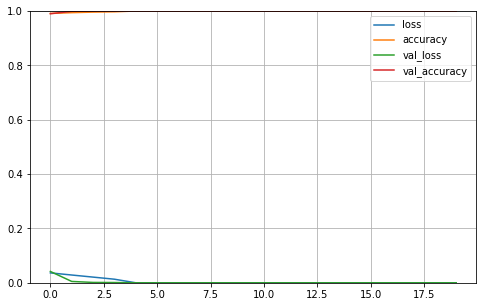

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
y_pred = model.predict(X_test)
print(zo_loss(y_test, y_pred))

0.01311204841371722


### Res-Net 34

In [ ]:
class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [
      keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False), 
      keras.layers.BatchNormalization(),
      self.activation, keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False), keras.layers.BatchNormalization()]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False), keras.layers.BatchNormalization()]
  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[32, 32, 3],
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 16, 16, 64)        9408      
_________________________________________________________________
batch_normalization_73 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
residual_unit_32 (ResidualUn (None, 8, 8, 64)          74240     
_________________________________________________________________
residual_unit_33 (ResidualUn (None, 8, 8, 64)          74240     
_________________________________________________________________
residual_unit_34 (ResidualUn (None, 8, 8, 64)         

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,y_train,
        epochs=20,
        validation_data=(X_val, y_val),
        verbose=1, shuffle=True)

In [ ]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

341/341 [==============================] - 3s 10ms/step - loss: 0.0320 - accuracy: 0.9907


[0.03203872963786125, 0.9907390475273132]

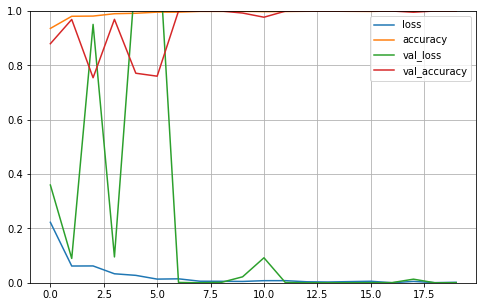

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
y_pred = model.predict(X_test)
print(zo_loss(y_test, y_pred))

0.009260957271226847


In [ ]:
#!pip install visualkeras
#import visualkeras
# visualkeras.layered_view(model, to_file='output.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and show

# visualkeras.layered_view(model)